# `pauc`: A Python Library for ROC Curve Analysis

## Installation

First, you'll need to install the `pauc` library. You can typically do this using `pip`:

```python
!pip install pauc
```

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

In [2]:
import pauc
from pauc.roc_core import ROC
from pauc.stats import compare, ci_auc, ci_sensitivity 
from pauc.plot import plot_roc

### The `ROC` Object

The `ROC` object has several useful attributes:

  * `roc.auc`: The Area Under the ROC Curve.
  * `roc.fpr`: An array of False Positive Rates.
  * `roc.tpr`: An array of True Positive Rates.
  * `roc.thresholds`: The thresholds used to calculate the FPR and TPR.
  * `roc.n_cases`: The number of positive samples.
  * `roc.n_controls`: The number of negative samples.

## Plotting ROC Curves

/var/folders/nj/v2qpgqmx5v95v_p1dzfj62yr0000gn/T/ipykernel_48679/3561562023.py:62: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  results_data = {k: pickle.load(open(v, 'rb')) for k, v in FILE_MAP.items()}


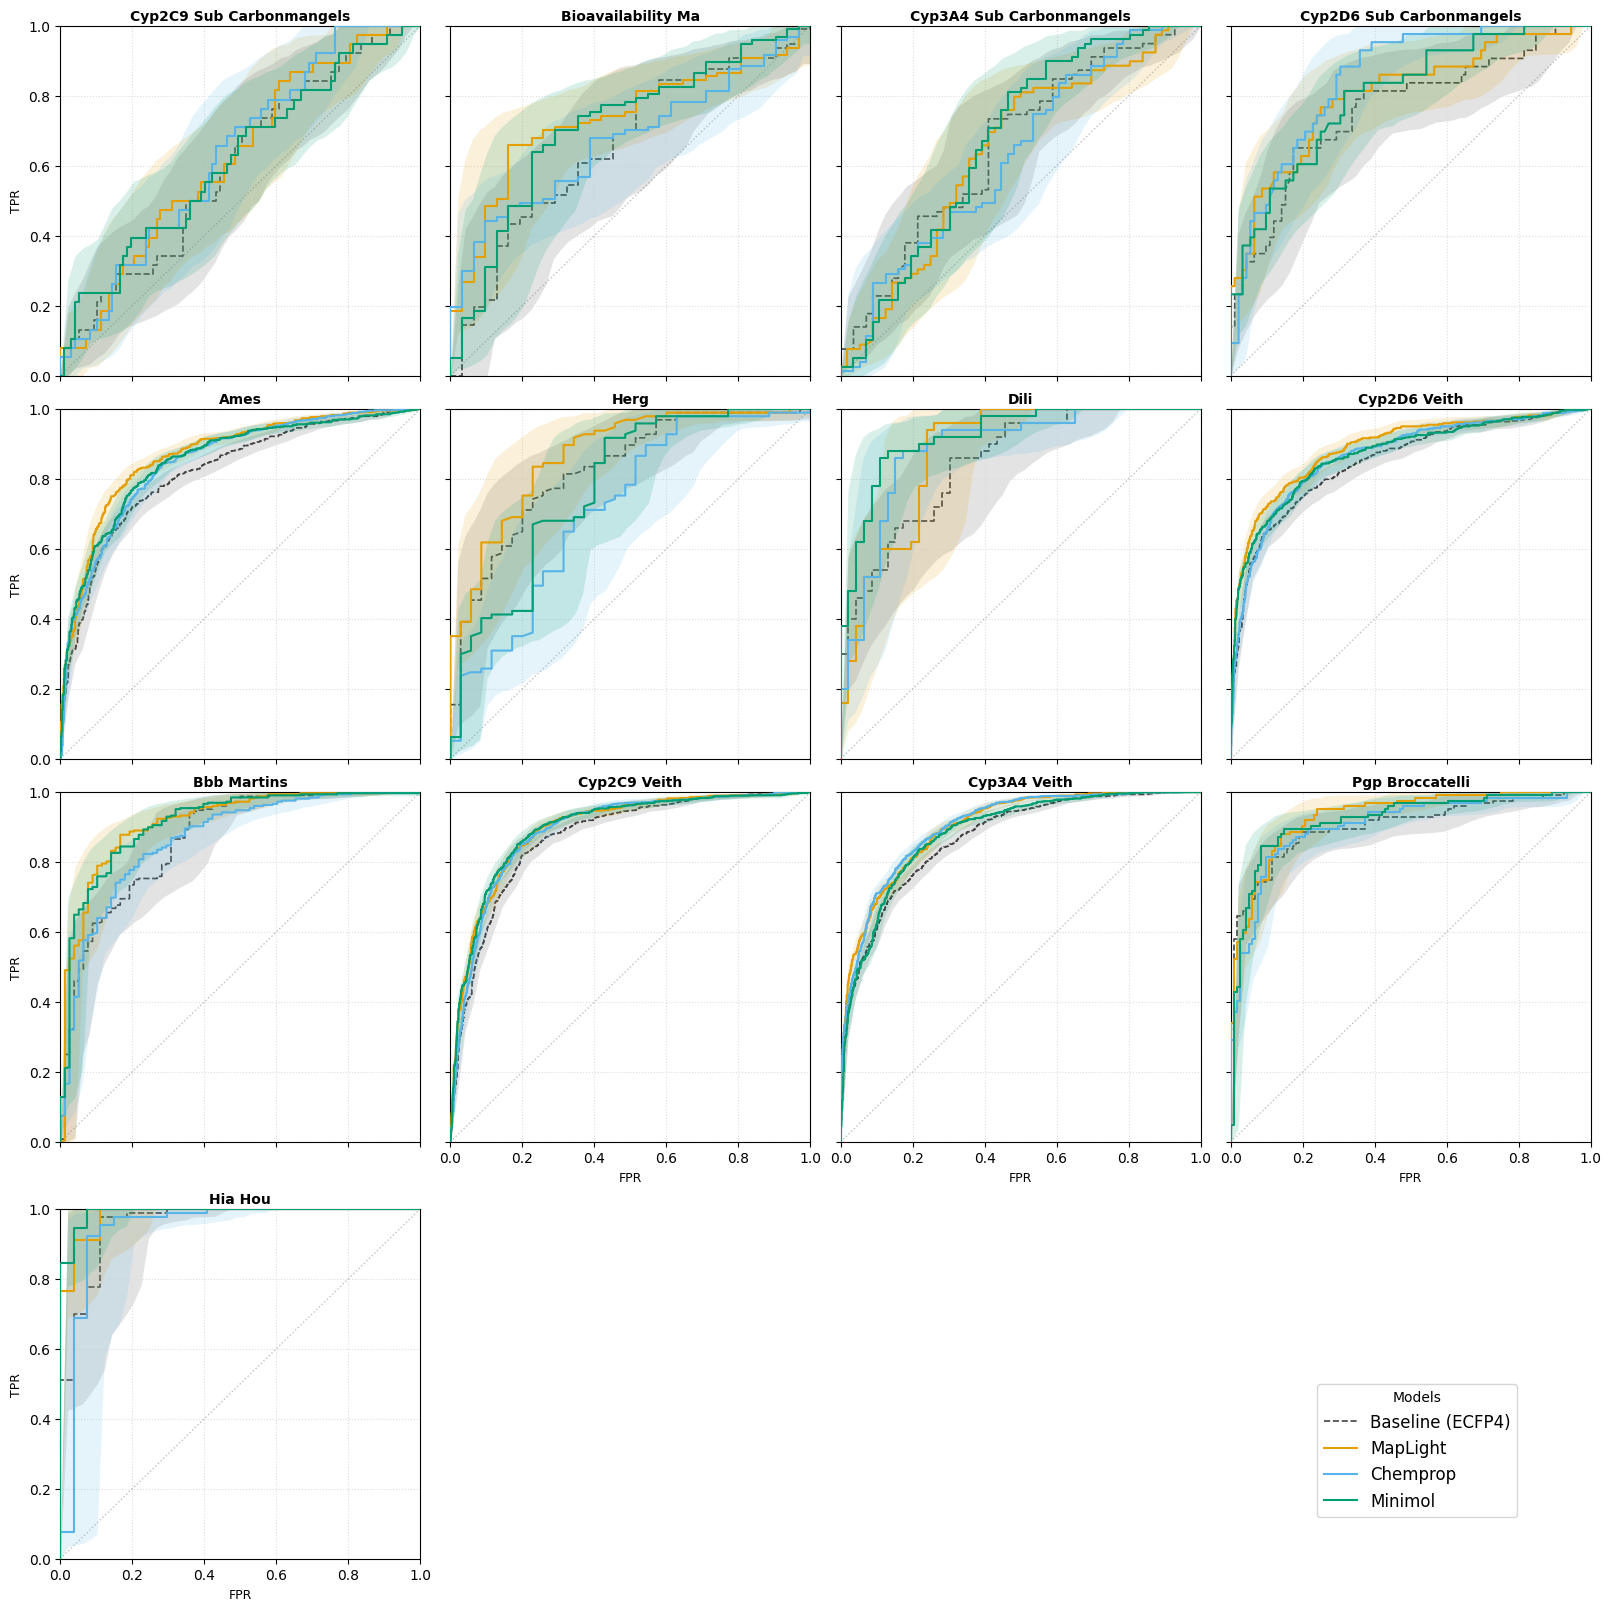

In [3]:
RESULTS_DIR = "plots"
os.makedirs(RESULTS_DIR, exist_ok=True)

COLORS = {
    'Baseline (ECFP4)': '#444444', 
    'MapLight': '#E69F00',          
    'Chemprop': '#56B4E9',          
    'Minimol': '#009E73'            
}

BENCHMARK_CONFIG = [
    'hia_hou', 'pgp_broccatelli', 'bioavailability_ma', 'bbb_martins',
    'cyp2c9_veith', 'cyp2d6_veith', 'cyp3a4_veith',
    'cyp2c9_substrate_carbonmangels', 'cyp2d6_substrate_carbonmangels',
    'cyp3a4_substrate_carbonmangels', 'herg', 'ames', 'dili'
]

FILE_MAP = {
    'Baseline (ECFP4)': '../benchmark/baseline/baseline_ecfp4_binary.pickle',
    'MapLight': '../benchmark/maplight/maplight_binary.pickle',
    'Chemprop': '../benchmark/chemprop/chemprop_binary.pickle',
    'Minimol': '../benchmark/minimol/minimol_binary.pickle'
}

def plot_on_axis_with_ci(ax, rocs, dataset_name, is_bottom, is_left):
    ax.plot([0, 1], [0, 1], linestyle=':', lw=1, color='grey', alpha=0.5)
    for roc in rocs:
        color = COLORS.get(roc.name, 'black')
        ls = '--' if 'Baseline' in roc.name else '-'
        lw = 1.2 if 'Baseline' in roc.name else 1.5
        zorder = 2 if 'Baseline' in roc.name else 3
        ax.plot(roc.fpr, roc.tpr, color=color, linestyle=ls, linewidth=lw, 
                label=f"{roc.name}", zorder=zorder)
        try:
            specificities = np.linspace(0, 1, 50) 
            lower, upper = ci_sensitivity(roc, specificities, n_boot=2000)
            x_axis = 1 - specificities
            sort_idx = np.argsort(x_axis)
            
            ax.fill_between(
                x_axis[sort_idx], lower[sort_idx], upper[sort_idx],
                color=color, alpha=0.15, zorder=zorder-1, linewidth=0
            )
        except Exception as e:
            print(f"Warning: Could not calc CI for {roc.name}: {e}")

    clean_title = dataset_name.replace('_', ' ').replace('substrate', 'sub').title()
    ax.set_title(clean_title, fontsize=10, weight='bold', pad=4)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle=':', color='#DDDDDD')
    
    if is_bottom: ax.set_xlabel("FPR", fontsize=9)
    else: ax.set_xticklabels([])
        
    if is_left: ax.set_ylabel("TPR", fontsize=9)
    else: ax.set_yticklabels([])

rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(16, 16), constrained_layout=True)
axes_flat = axes.flatten()
results_data = {k: pickle.load(open(v, 'rb')) for k, v in FILE_MAP.items()}

dataset_difficulty = {}

for dataset in BENCHMARK_CONFIG:
    d_base = results_data['Baseline (ECFP4)']
    pred_key = f"{dataset}_y_pred_proba"
    true_key = f"{dataset}_y_true"
    
    if pred_key in d_base:
        y_score = d_base[pred_key]
        if y_score.ndim > 1: y_score = y_score[:, 1] if y_score.shape[1] == 2 else y_score.squeeze()
        
        if not np.isnan(y_score).any():
            base_roc = ROC(d_base[true_key], y_score)
            dataset_difficulty[dataset] = base_roc.auc

SORTED_CONFIG = sorted(BENCHMARK_CONFIG, key=lambda x: dataset_difficulty.get(x, 0))

for i, dataset in enumerate(SORTED_CONFIG):
    ax = axes_flat[i]
    rocs = []
    
    for model_name, data in results_data.items():
        pred_key = f"{dataset}_y_pred_proba"
        true_key = f"{dataset}_y_true"
        if pred_key in data:
            y_score = data[pred_key]
            if y_score.ndim > 1: y_score = y_score[:, 1] if y_score.shape[1] == 2 else y_score.squeeze()
            if not np.isnan(y_score).any():
                rocs.append(ROC(data[true_key], y_score, name=model_name))
    
    if rocs:
        is_bottom = (i // cols == rows - 1) or (i + cols >= len(BENCHMARK_CONFIG))
        is_left = (i % cols == 0)
        plot_on_axis_with_ci(ax, rocs, dataset, is_bottom, is_left)

for j in range(len(BENCHMARK_CONFIG), len(axes_flat)): 
    axes_flat[j].axis('off')

handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.95, 0.05), fontsize=12, title="Models")

plt.savefig(f"{RESULTS_DIR}/roc_grid_with_ci.pdf", dpi=300)
plt.show()

/var/folders/nj/v2qpgqmx5v95v_p1dzfj62yr0000gn/T/ipykernel_48679/422103100.py:51: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  results_data = {k: pickle.load(open(v, 'rb')) for k, v in FILE_MAP.items()}


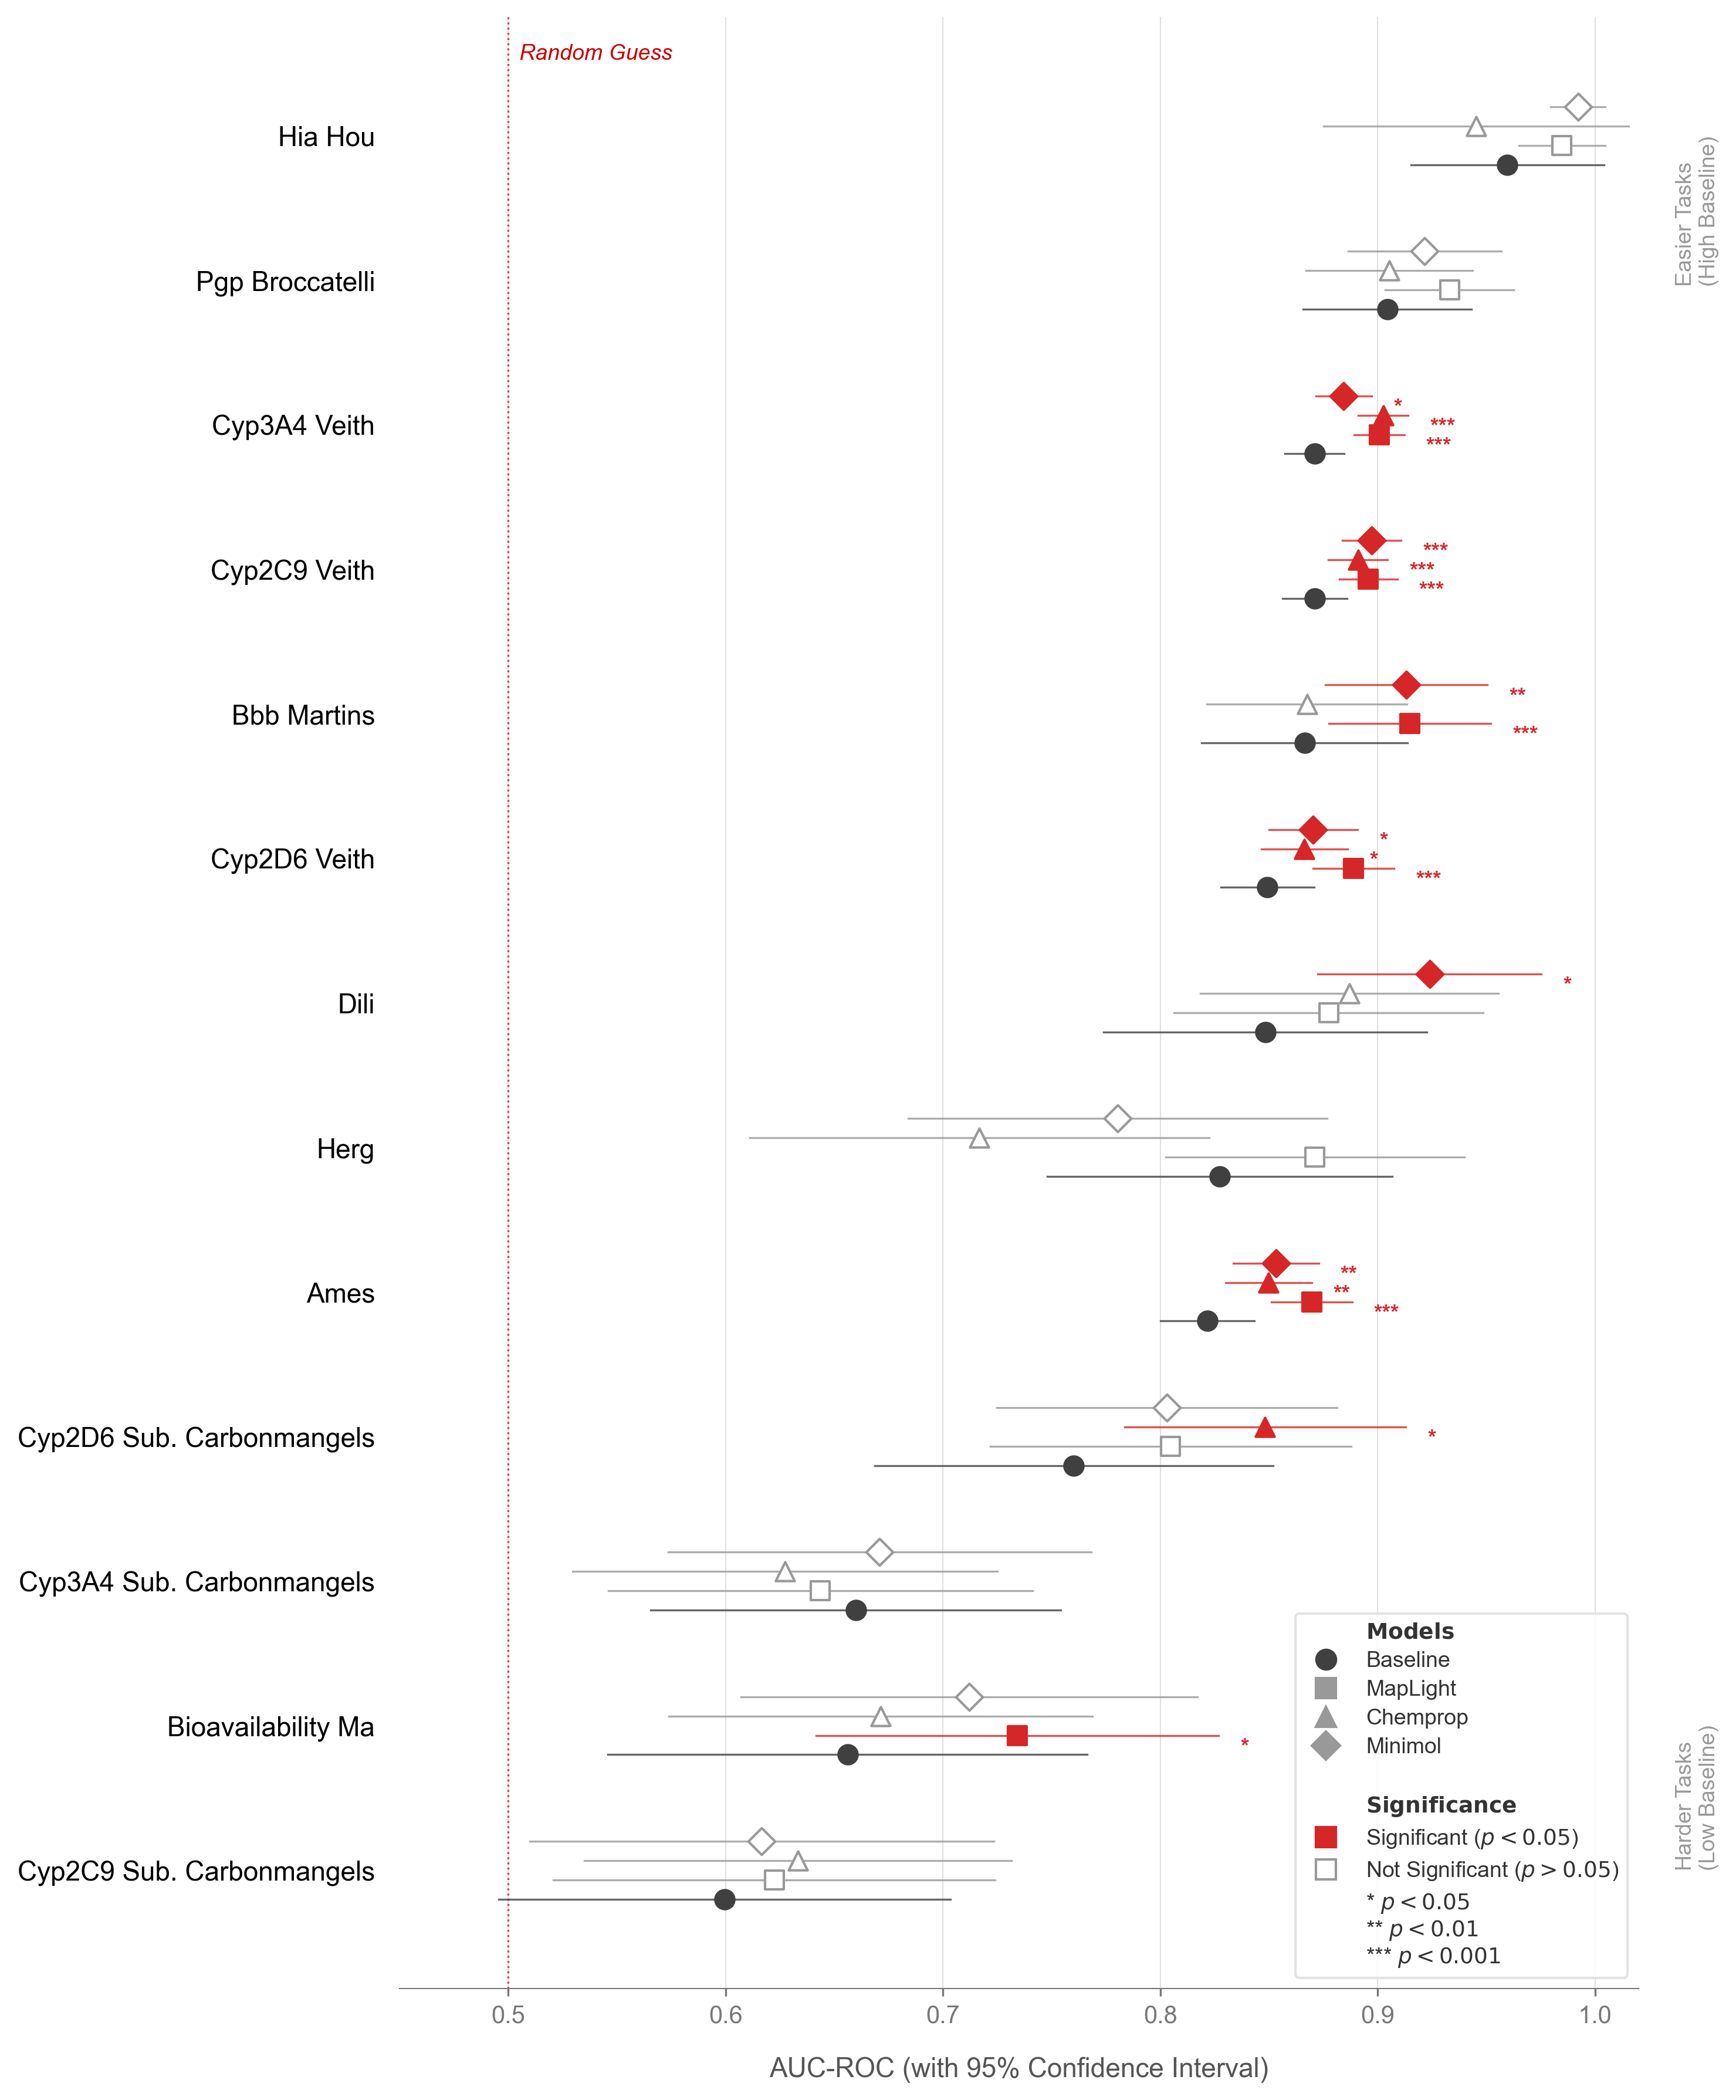

In [4]:
RESULTS_DIR = "plots"

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 10,
    'axes.linewidth': 0.5,
    'axes.edgecolor': '#777777',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'ytick.major.size': 0,
    'xtick.major.size': 3,
    'xtick.color': '#777777',
    'xtick.direction': 'out',
    'figure.dpi': 300,
    'legend.frameon': False,
    'grid.color': '#E0E0E0',
    'grid.linewidth': 0.5,
    'text.color': '#333333'
})

COLOR_SIG = '#D62728'    
COLOR_NONSIG = '#999999' 
COLOR_BASE = '#404040'   
COLOR_RANDOM = '#CC0000' 

MARKERS = {
    'Baseline (ECFP4)': 'o',
    'MapLight': 's',
    'Chemprop': '^',
    'Minimol': 'D'
}

MODEL_ORDER = ['Baseline (ECFP4)', 'MapLight', 'Chemprop', 'Minimol']

BENCHMARK_CONFIG = [
    'hia_hou', 'pgp_broccatelli', 'bioavailability_ma', 'bbb_martins',
    'cyp2c9_veith', 'cyp2d6_veith', 'cyp3a4_veith',
    'cyp2c9_substrate_carbonmangels', 'cyp2d6_substrate_carbonmangels',
    'cyp3a4_substrate_carbonmangels', 'herg', 'ames', 'dili'
]

FILE_MAP = {
    'Baseline (ECFP4)': '../benchmark/baseline/baseline_ecfp4_binary.pickle',
    'MapLight': '../benchmark/maplight/maplight_binary.pickle',
    'Chemprop': '../benchmark/chemprop/chemprop_binary.pickle',
    'Minimol': '../benchmark/minimol/minimol_binary.pickle'
}

results_data = {k: pickle.load(open(v, 'rb')) for k, v in FILE_MAP.items()}
forest_data = []
baseline_rocs = {}

for dataset in BENCHMARK_CONFIG:
    data = results_data['Baseline (ECFP4)']
    pred_key = f"{dataset}_y_pred_proba"
    if pred_key in data:
        y_score = data[pred_key]
        if y_score.ndim > 1: y_score = y_score[:, 1] if y_score.shape[1] == 2 else y_score.squeeze()
        if not np.isnan(y_score).any():
            baseline_rocs[dataset] = ROC(data[f"{dataset}_y_true"], y_score)

for dataset in BENCHMARK_CONFIG:
    base_roc = baseline_rocs.get(dataset)
    for model_name in MODEL_ORDER:
        data = results_data[model_name]
        pred_key = f"{dataset}_y_pred_proba"
        true_key = f"{dataset}_y_true"
        
        if pred_key in data:
            y_score = data[pred_key]
            if y_score.ndim > 1: y_score = y_score[:, 1] if y_score.shape[1] == 2 else y_score.squeeze()
            
            if not np.isnan(y_score).any():
                roc = ROC(data[true_key], y_score)
                lower, upper = ci_auc(roc, method='delong')
                
                is_sig = False
                sig_label = ""
                if model_name != 'Baseline (ECFP4)' and base_roc:
                    try:
                        res = compare(roc, base_roc, method='delong')
                        if res.p_value < 0.05 and roc.auc > base_roc.auc:
                            is_sig = True
                            if res.p_value < 0.001: sig_label = "***"
                            elif res.p_value < 0.01: sig_label = "**"
                            else: sig_label = "*"
                    except: pass

                forest_data.append({
                    'Dataset': dataset, 'Model': model_name, 'AUC': roc.auc,
                    'Lower': lower, 'Upper': upper,
                    'Significant': is_sig, 'Sig_Label': sig_label
                })

df = pd.DataFrame(forest_data)
base_scores = df[df['Model'] == 'Baseline (ECFP4)'].set_index('Dataset')['AUC']
sorted_datasets = base_scores.sort_values().index.tolist()
sorted_datasets.extend([d for d in BENCHMARK_CONFIG if d not in sorted_datasets])

fig, ax = plt.subplots(figsize=(11, 14))

y_positions = np.arange(len(sorted_datasets))
offsets = np.linspace(-0.2, 0.2, len(MODEL_ORDER))

ax.grid(True, axis='x', linestyle='-')
ax.set_axisbelow(True)

ax.axvline(0.5, color=COLOR_RANDOM, linestyle=':', linewidth=0.8, alpha=0.7, zorder=1)
ax.text(0.505, len(sorted_datasets)-0.5, 'Random Guess', color=COLOR_RANDOM,
        fontsize=9, va='bottom', style='italic')

for i, dataset in enumerate(sorted_datasets):
    base_y = y_positions[i]
    
    for j, model_name in enumerate(MODEL_ORDER):
        row = df[(df['Dataset'] == dataset) & (df['Model'] == model_name)]
        if row.empty: continue
        row = row.iloc[0]
        
        y_pos = base_y + offsets[j]
        is_sig = row['Significant']
        is_base = (model_name == 'Baseline (ECFP4)')
        marker = MARKERS[model_name]

        if is_base:
            plot_color = COLOR_BASE
            face_color = COLOR_BASE
            z_order = 5
        elif is_sig:
            plot_color = COLOR_SIG
            face_color = COLOR_SIG
            z_order = 6
        else:
            plot_color = COLOR_NONSIG
            face_color = 'white'
            z_order = 4

        ax.plot([row['Lower'], row['Upper']], [y_pos, y_pos], color=plot_color, 
                linewidth=0.8, alpha=0.8, zorder=2)
        ax.scatter(row['AUC'], y_pos, s=60, marker=marker,
                   facecolors=face_color, edgecolors=plot_color, linewidth=1.0, 
                   zorder=z_order)
        if is_sig:
            ax.text(row['Upper'] + 0.01, y_pos - 0.08, row['Sig_Label'], 
                    color=COLOR_SIG, fontsize=9, fontweight='bold', ha='left', va='center')

dataset_labels = [d.replace('_', ' ').replace('substrate', 'sub.').title() for d in sorted_datasets]
ax.set_yticks(y_positions)
ax.set_yticklabels(dataset_labels, fontsize=11)
ax.tick_params(axis='y', pad=10)

ax.set_xlabel("AUC-ROC (with 95% Confidence Interval)", fontsize=11, labelpad=12, color='#555555')
ax.set_xlim(0.45, 1.02)
ax.xaxis.set_major_locator(MultipleLocator(0.1))

ax.text(1.03, 0, "Harder Tasks\n(Low Baseline)", transform=ax.get_yaxis_transform(),
        rotation=90, va='bottom', ha='left', color='#999999', fontsize=9)
ax.text(1.03, len(sorted_datasets)-1, "Easier Tasks\n(High Baseline)", transform=ax.get_yaxis_transform(),
        rotation=90, va='top', ha='left', color='#999999', fontsize=9)

legend_elements = [
    Line2D([0], [0], color='w', label='$\\bf{Models}$'),
    Line2D([0], [0], marker=MARKERS['Baseline (ECFP4)'], color='w', mfc=COLOR_BASE, mec=COLOR_BASE, ms=8, label='Baseline'),
    Line2D([0], [0], marker=MARKERS['MapLight'], color='w', mfc=COLOR_NONSIG, mec=COLOR_NONSIG, ms=8, label='MapLight'),
    Line2D([0], [0], marker=MARKERS['Chemprop'], color='w', mfc=COLOR_NONSIG, mec=COLOR_NONSIG, ms=8, label='Chemprop'),
    Line2D([0], [0], marker=MARKERS['Minimol'], color='w', mfc=COLOR_NONSIG, mec=COLOR_NONSIG, ms=8, label='Minimol'),
    Line2D([0], [0], color='w', label=''), 
    Line2D([0], [0], color='w', label='$\\bf{Significance}$'),
    Line2D([0], [0], marker='s', color='w', mfc=COLOR_SIG, mec=COLOR_SIG, ms=8, label='Significant ($p < 0.05$)'),
    Line2D([0], [0], marker='s', color='w', mfc='white', mec=COLOR_NONSIG, ms=8, label='Not Significant ($p > 0.05$)'),
    Line2D([0], [0], marker='', color='w', label='* $p<0.05$\n** $p<0.01$\n*** $p<0.001$')
]

ax.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1.0, 0.0),
          frameon=True, fancybox=True, framealpha=0.9, edgecolor='#E0E0E0',
          fontsize=9, labelspacing=0.4)

plt.tight_layout()
plt.subplots_adjust(top=0.88, right=0.92, left=0.28, bottom=0.08)

save_path = f"{RESULTS_DIR}/final_consolidated_legend.pdf"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

In [5]:
RESULTS_DIR = "tables"
os.makedirs(RESULTS_DIR, exist_ok=True)

BENCHMARK_CONFIG = [
    'hia_hou', 'pgp_broccatelli', 'bioavailability_ma', 'bbb_martins',
    'cyp2c9_veith', 'cyp2d6_veith', 'cyp3a4_veith',
    'cyp2c9_substrate_carbonmangels', 'cyp2d6_substrate_carbonmangels',
    'cyp3a4_substrate_carbonmangels', 'herg', 'ames', 'dili'
]

FILE_MAP = {
    'Baseline (ECFP4)': '../benchmark/baseline/baseline_ecfp4_binary.pickle',
    'MapLight': '../benchmark/maplight/maplight_binary.pickle',
    'Chemprop': '../benchmark/chemprop/chemprop_binary.pickle',
    'Minimol': '../benchmark/minimol/minimol_binary.pickle'
}

MODEL_ORDER = ['Baseline (ECFP4)', 'MapLight', 'Chemprop', 'Minimol']

results_data = {k: pickle.load(open(v, 'rb')) for k, v in FILE_MAP.items()}
table_rows = []
baseline_rocs = {}

for dataset in BENCHMARK_CONFIG:
    data = results_data['Baseline (ECFP4)']
    if f"{dataset}_y_pred_proba" in data:
        y_score = data[f"{dataset}_y_pred_proba"]
        if y_score.ndim > 1: y_score = y_score[:, 1] if y_score.shape[1] == 2 else y_score.squeeze()
        if not np.isnan(y_score).any():
            baseline_rocs[dataset] = ROC(data[f"{dataset}_y_true"], y_score)

for dataset in BENCHMARK_CONFIG:
    row_data = {'Dataset': dataset.replace('_', ' ').replace('substrate', 'sub.').title()}
    base_roc = baseline_rocs.get(dataset)
    row_data['_sort_val'] = base_roc.auc if base_roc else 0
    
    for model_name in MODEL_ORDER:
        data = results_data[model_name]
        pred_key = f"{dataset}_y_pred_proba"
        true_key = f"{dataset}_y_true"
        cell_str = "-"
        
        if pred_key in data:
            y_score = data[pred_key]
            if y_score.ndim > 1: y_score = y_score[:, 1] if y_score.shape[1] == 2 else y_score.squeeze()
            
            if not np.isnan(y_score).any():
                roc = ROC(data[true_key], y_score)
                lower, upper = ci_auc(roc, method='delong')
                stars = ""
                if model_name != 'Baseline (ECFP4)' and base_roc:
                    try:
                        res = compare(roc, base_roc, method='delong')
                        if res.p_value < 0.05 and roc.auc > base_roc.auc:
                            if res.p_value < 0.001: stars = "***"
                            elif res.p_value < 0.01: stars = "**"
                            else: stars = "*"
                    except: pass
                
                cell_str = f"{roc.auc:.3f} [{lower:.3f}-{upper:.3f}]{stars}"
        row_data[model_name] = cell_str
    table_rows.append(row_data)


df = pd.DataFrame(table_rows)
df = df.sort_values(by='_sort_val', ascending=True).drop(columns=['_sort_val'])
df.columns = df.columns.str.replace('Baseline (ECFP4)', 'Baseline')
csv_path = f"{RESULTS_DIR}/benchmark_results_table.csv"
df.to_csv(csv_path, index=False)
df

/var/folders/nj/v2qpgqmx5v95v_p1dzfj62yr0000gn/T/ipykernel_48679/1923913366.py:20: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  results_data = {k: pickle.load(open(v, 'rb')) for k, v in FILE_MAP.items()}


,Dataset,Baseline,MapLight,Chemprop,Minimol
7,Cyp2C9 Sub. Carbonmangels,0.600 [0.496-0.704],0.622 [0.521-0.724],0.633 [0.535-0.731],0.617 [0.510-0.723]
2,Bioavailability Ma,0.656 [0.546-0.766],0.734 [0.642-0.827]*,0.671 [0.574-0.769],0.712 [0.607-0.817]
9,Cyp3A4 Sub. Carbonmangels,0.660 [0.566-0.754],0.644 [0.546-0.741],0.627 [0.530-0.725],0.671 [0.574-0.768]
8,Cyp2D6 Sub. Carbonmangels,0.760 [0.669-0.852],0.805 [0.722-0.888],0.848 [0.784-0.913]*,0.803 [0.725-0.881]
11,Ames,0.822 [0.800-0.843],0.870 [0.851-0.888]***,0.850 [0.830-0.870]**,0.853 [0.834-0.873]**
10,Herg,0.827 [0.748-0.907],0.871 [0.802-0.940],0.717 [0.611-0.823],0.780 [0.684-0.877]
12,Dili,0.848 [0.774-0.923],0.877 [0.806-0.948],0.887 [0.818-0.955],0.924 [0.873-0.975]*
5,Cyp2D6 Veith,0.849 [0.828-0.871],0.889 [0.870-0.908]***,0.866 [0.846-0.886]*,0.870 [0.850-0.891]*
3,Bbb Martins,0.866 [0.819-0.914],0.915 [0.878-0.952]***,0.867 [0.821-0.914],0.913 [0.876-0.950]**
4,Cyp2C9 Veith,0.871 [0.856-0.886],0.896 [0.882-0.909]***,0.891 [0.877-0.905]***,0.897 [0.884-0.911]***


/var/folders/nj/v2qpgqmx5v95v_p1dzfj62yr0000gn/T/ipykernel_48679/1684664609.py:25: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  results_data = {k: pickle.load(open(v, 'rb')) for k, v in FILE_MAP.items()}


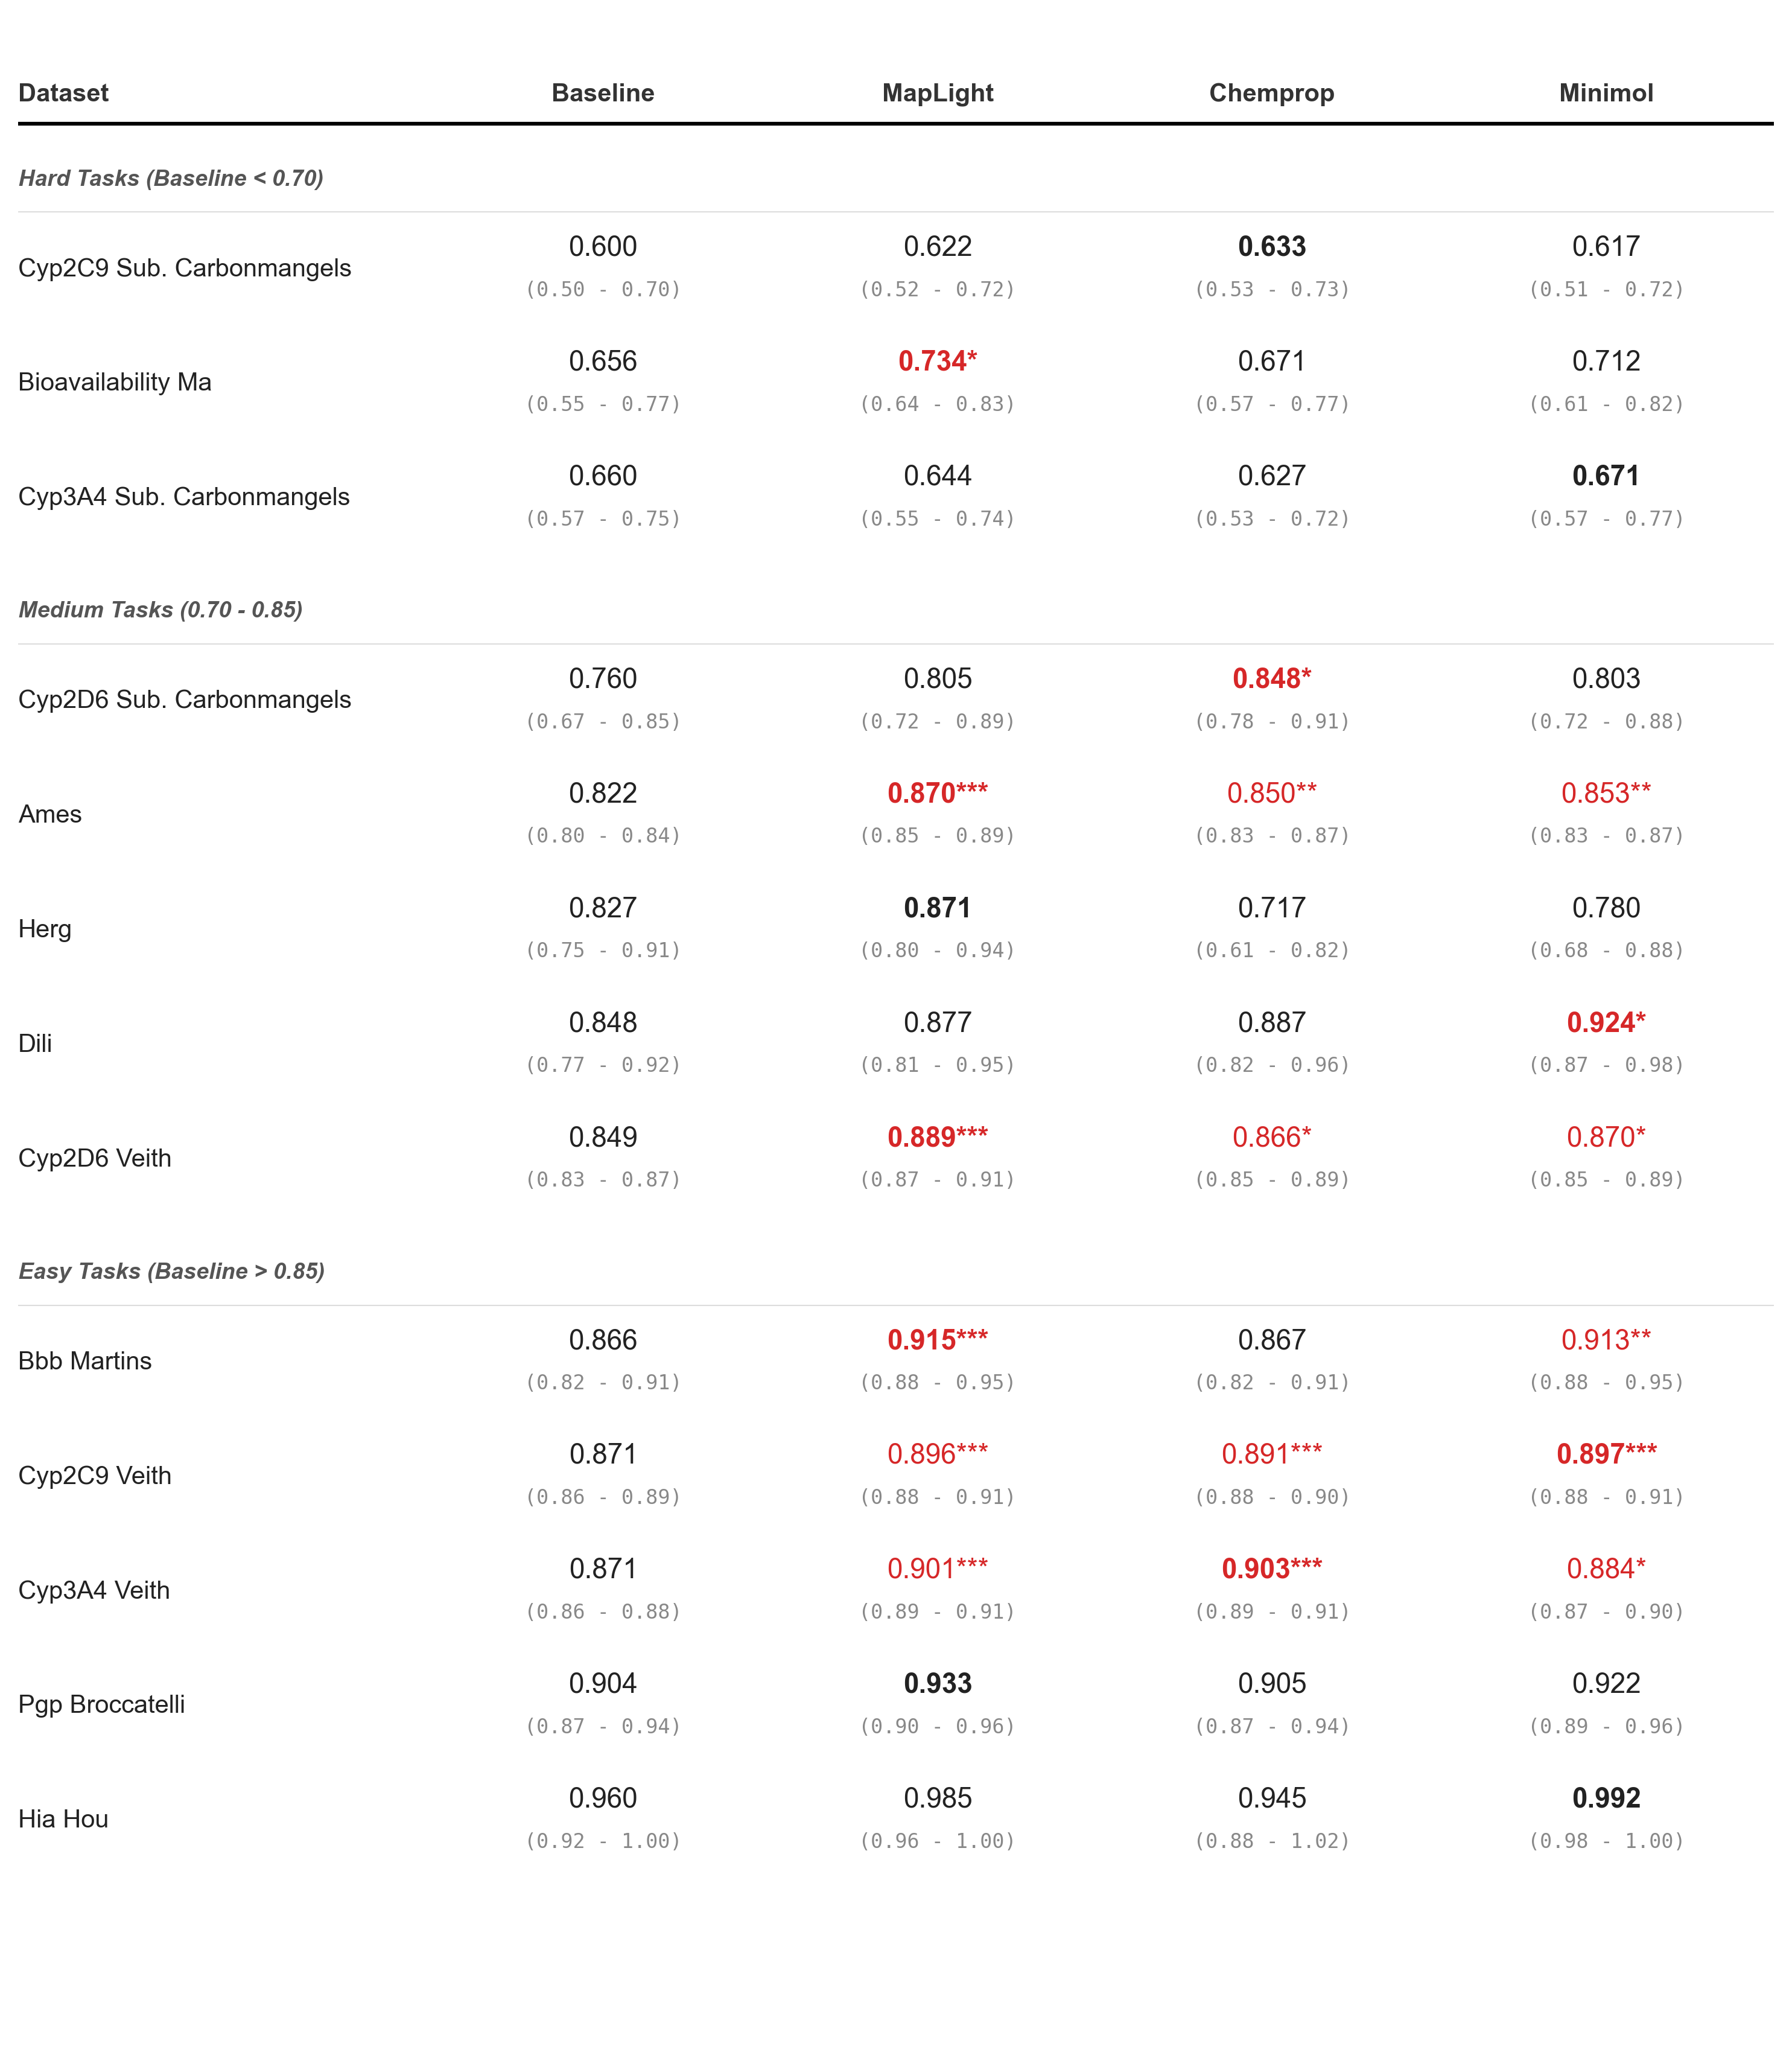

In [7]:
RESULTS_DIR = "tables"

C_TEXT_MAIN = '#222222'
C_TEXT_LIGHT = '#888888'  
C_SIG_RED = '#D62728'     
C_BG_ROW = '#FAFAFA'      

BENCHMARK_CONFIG = [
    'hia_hou', 'pgp_broccatelli', 'bioavailability_ma', 'bbb_martins',
    'cyp2c9_veith', 'cyp2d6_veith', 'cyp3a4_veith',
    'cyp2c9_substrate_carbonmangels', 'cyp2d6_substrate_carbonmangels',
    'cyp3a4_substrate_carbonmangels', 'herg', 'ames', 'dili'
]

FILE_MAP = {
    'Baseline (ECFP4)': '../benchmark/baseline/baseline_ecfp4_binary.pickle',
    'MapLight': '../benchmark/maplight/maplight_binary.pickle',
    'Chemprop': '../benchmark/chemprop/chemprop_binary.pickle',
    'Minimol': '../benchmark/minimol/minimol_binary.pickle'
}

MODEL_LABELS = ['Baseline', 'MapLight', 'Chemprop', 'Minimol']
MODEL_KEYS = ['Baseline (ECFP4)', 'MapLight', 'Chemprop', 'Minimol']

results_data = {k: pickle.load(open(v, 'rb')) for k, v in FILE_MAP.items()}
data_rows = []
baseline_rocs = {}

for dataset in BENCHMARK_CONFIG:
    d = results_data['Baseline (ECFP4)']
    pk = f"{dataset}_y_pred_proba"
    if pk in d:
        ys = d[pk]
        if ys.ndim > 1: ys = ys[:, 1] if ys.shape[1]==2 else ys.squeeze()
        if not np.isnan(ys).any():
            baseline_rocs[dataset] = ROC(d[f"{dataset}_y_true"], ys)

for dataset in BENCHMARK_CONFIG:
    base_roc = baseline_rocs.get(dataset)
    difficulty = base_roc.auc if base_roc else 0
    
    row_vals = []
    best_auc = -1
    
    for m_key in MODEL_KEYS:
        d = results_data[m_key]
        pk = f"{dataset}_y_pred_proba"
        
        val = {'auc': np.nan, 'ci': (np.nan, np.nan), 'sig': False, 'stars': ''}
        
        if pk in d:
            ys = d[pk]
            if ys.ndim > 1: ys = ys[:, 1] if ys.shape[1]==2 else ys.squeeze()
            if not np.isnan(ys).any():
                roc = ROC(d[f"{dataset}_y_true"], ys)
                l, u = ci_auc(roc, method='delong')
                val['auc'] = roc.auc
                val['ci'] = (l, u)
                if m_key != 'Baseline (ECFP4)' and base_roc:
                    try:
                        res = compare(roc, base_roc, method='delong')
                        if res.p_value < 0.05 and roc.auc > base_roc.auc:
                            val['sig'] = True
                            val['stars'] = '*' if res.p_value > 0.01 else ('**' if res.p_value > 0.001 else '***')
                    except: pass
        
        if not np.isnan(val['auc']) and val['auc'] > best_auc:
            best_auc = val['auc']
            
        row_vals.append(val)

    for v in row_vals:
        if not np.isnan(v['auc']) and v['auc'] == best_auc:
            v['is_best'] = True
        else:
            v['is_best'] = False

    data_rows.append({
        'name': dataset.replace('_', ' ').replace('substrate', 'Sub.').title(),
        'sort_val': difficulty,
        'values': row_vals
    })

data_rows.sort(key=lambda x: x['sort_val'])
grouped_rows = []
if len(data_rows) > 0:
    grouped_rows.append({'type': 'header', 'text': 'Hard Tasks (Baseline < 0.70)'})
    for r in data_rows:
        if r['sort_val'] < 0.70: grouped_rows.append({'type': 'data', **r})
    
    grouped_rows.append({'type': 'header', 'text': 'Medium Tasks (0.70 - 0.85)'})
    for r in data_rows:
        if 0.70 <= r['sort_val'] < 0.85: grouped_rows.append({'type': 'data', **r})
        
    grouped_rows.append({'type': 'header', 'text': 'Easy Tasks (Baseline > 0.85)'})
    for r in data_rows:
        if r['sort_val'] >= 0.85: grouped_rows.append({'type': 'data', **r})

h_row = 0.65
h_header = 0.5
n_rows = len(grouped_rows) + 2 
w_cols = [2.5, 2.0, 2.0, 2.0, 2.0]
total_h = sum([h_header if r.get('type')=='header' else h_row for r in grouped_rows]) + 1.5

fig, ax = plt.subplots(figsize=(10, total_h))
ax.axis('off')
ax.set_ylim(0, total_h)
ax.set_xlim(0, sum(w_cols))

y_curr = total_h - 0.5

# y_curr -= 0.6
x_curr = 0
for i, col_name in enumerate(["Dataset"] + MODEL_LABELS):
    align = 'left' if i == 0 else 'center'
    ax.text(x_curr + (0 if i==0 else w_cols[i]/2), y_curr, col_name, 
            weight='bold', fontsize=10, ha=align, va='bottom')
    x_curr += w_cols[i]

ax.plot([0, sum(w_cols)], [y_curr-0.1, y_curr-0.1], color='black', lw=1.5)
y_curr -= 0.1

for i, row in enumerate(grouped_rows):
    if row['type'] == 'header':
        y_curr -= h_header
        # Draw section sub-header
        ax.text(0, y_curr + 0.15, row['text'], fontsize=9, weight='bold', 
                color='#555555', style='italic')
        ax.plot([0, sum(w_cols)], [y_curr, y_curr], color='#DDDDDD', lw=0.5)
        
    else: # type == data
        y_curr -= h_row
        yc = y_curr + h_row/2 
        ax.text(0, yc, row['name'], fontsize=10, ha='left', va='center', color=C_TEXT_MAIN)
        
        x_c = w_cols[0]
        for v in row['values']:
            if np.isnan(v['auc']):
                ax.text(x_c + w_cols[1]/2, yc, "—", ha='center', va='center', color=C_TEXT_LIGHT)
            else:
                is_sig = v['sig']
                is_best = v['is_best']
                
                txt_color = C_SIG_RED if is_sig else C_TEXT_MAIN
                weight = 'bold' if is_best else 'normal'
                
                ax.text(x_c + w_cols[1]/2, yc + 0.12, f"{v['auc']:.3f}{v['stars']}", 
                        fontsize=11, ha='center', va='center', 
                        color=txt_color, weight=weight)
                
                ci_txt = f"({v['ci'][0]:.2f} - {v['ci'][1]:.2f})"
                ax.text(x_c + w_cols[1]/2, yc - 0.12, ci_txt, 
                        fontsize=8, ha='center', va='center', 
                        color=C_TEXT_LIGHT, family='monospace')
                
            x_c += w_cols[1]

plt.tight_layout()
save_path = f"{RESULTS_DIR}/tufte_leaderboard.pdf"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

## Comparing ROC Curves

A common task in ROC analysis is to determine if the difference in AUC between two models is statistically significant. The `compare` function allows you to do this.

The `compare` function supports several comparison methods:

  * **`delong`**: DeLong's test for correlated or uncorrelated ROC curves. This is a common and powerful non-parametric test.
  * **`bootstrap`**: A bootstrap test for comparing AUCs. This is computationally more intensive but can be more flexible.
  * **`venkatraman`**: Venkatraman's test, which compares the entire shape of the ROC curves, not just the AUC.

The `compare` function also has a `paired` parameter. If your models were tested on the same dataset, you should set `paired=True` (which is the default if the true labels are the same).

## Confidence Intervals

The `pauc` library provides functions to calculate confidence intervals for various ROC metrics.

### AUC Confidence Interval

You can calculate the confidence interval for the AUC using `ci_auc`:

<>:131: SyntaxWarning: invalid escape sequence '\ '
<>:131: SyntaxWarning: invalid escape sequence '\ '
/var/folders/nj/v2qpgqmx5v95v_p1dzfj62yr0000gn/T/ipykernel_48679/3313133451.py:131: SyntaxWarning: invalid escape sequence '\ '
  Line2D([0], [0], marker='', color='w', label='$\\bf{Dot\ Order:}$'),
/var/folders/nj/v2qpgqmx5v95v_p1dzfj62yr0000gn/T/ipykernel_48679/3313133451.py:39: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  results_data = {k: pickle.load(open(v, 'rb')) for k, v in FILE_MAP.items()}


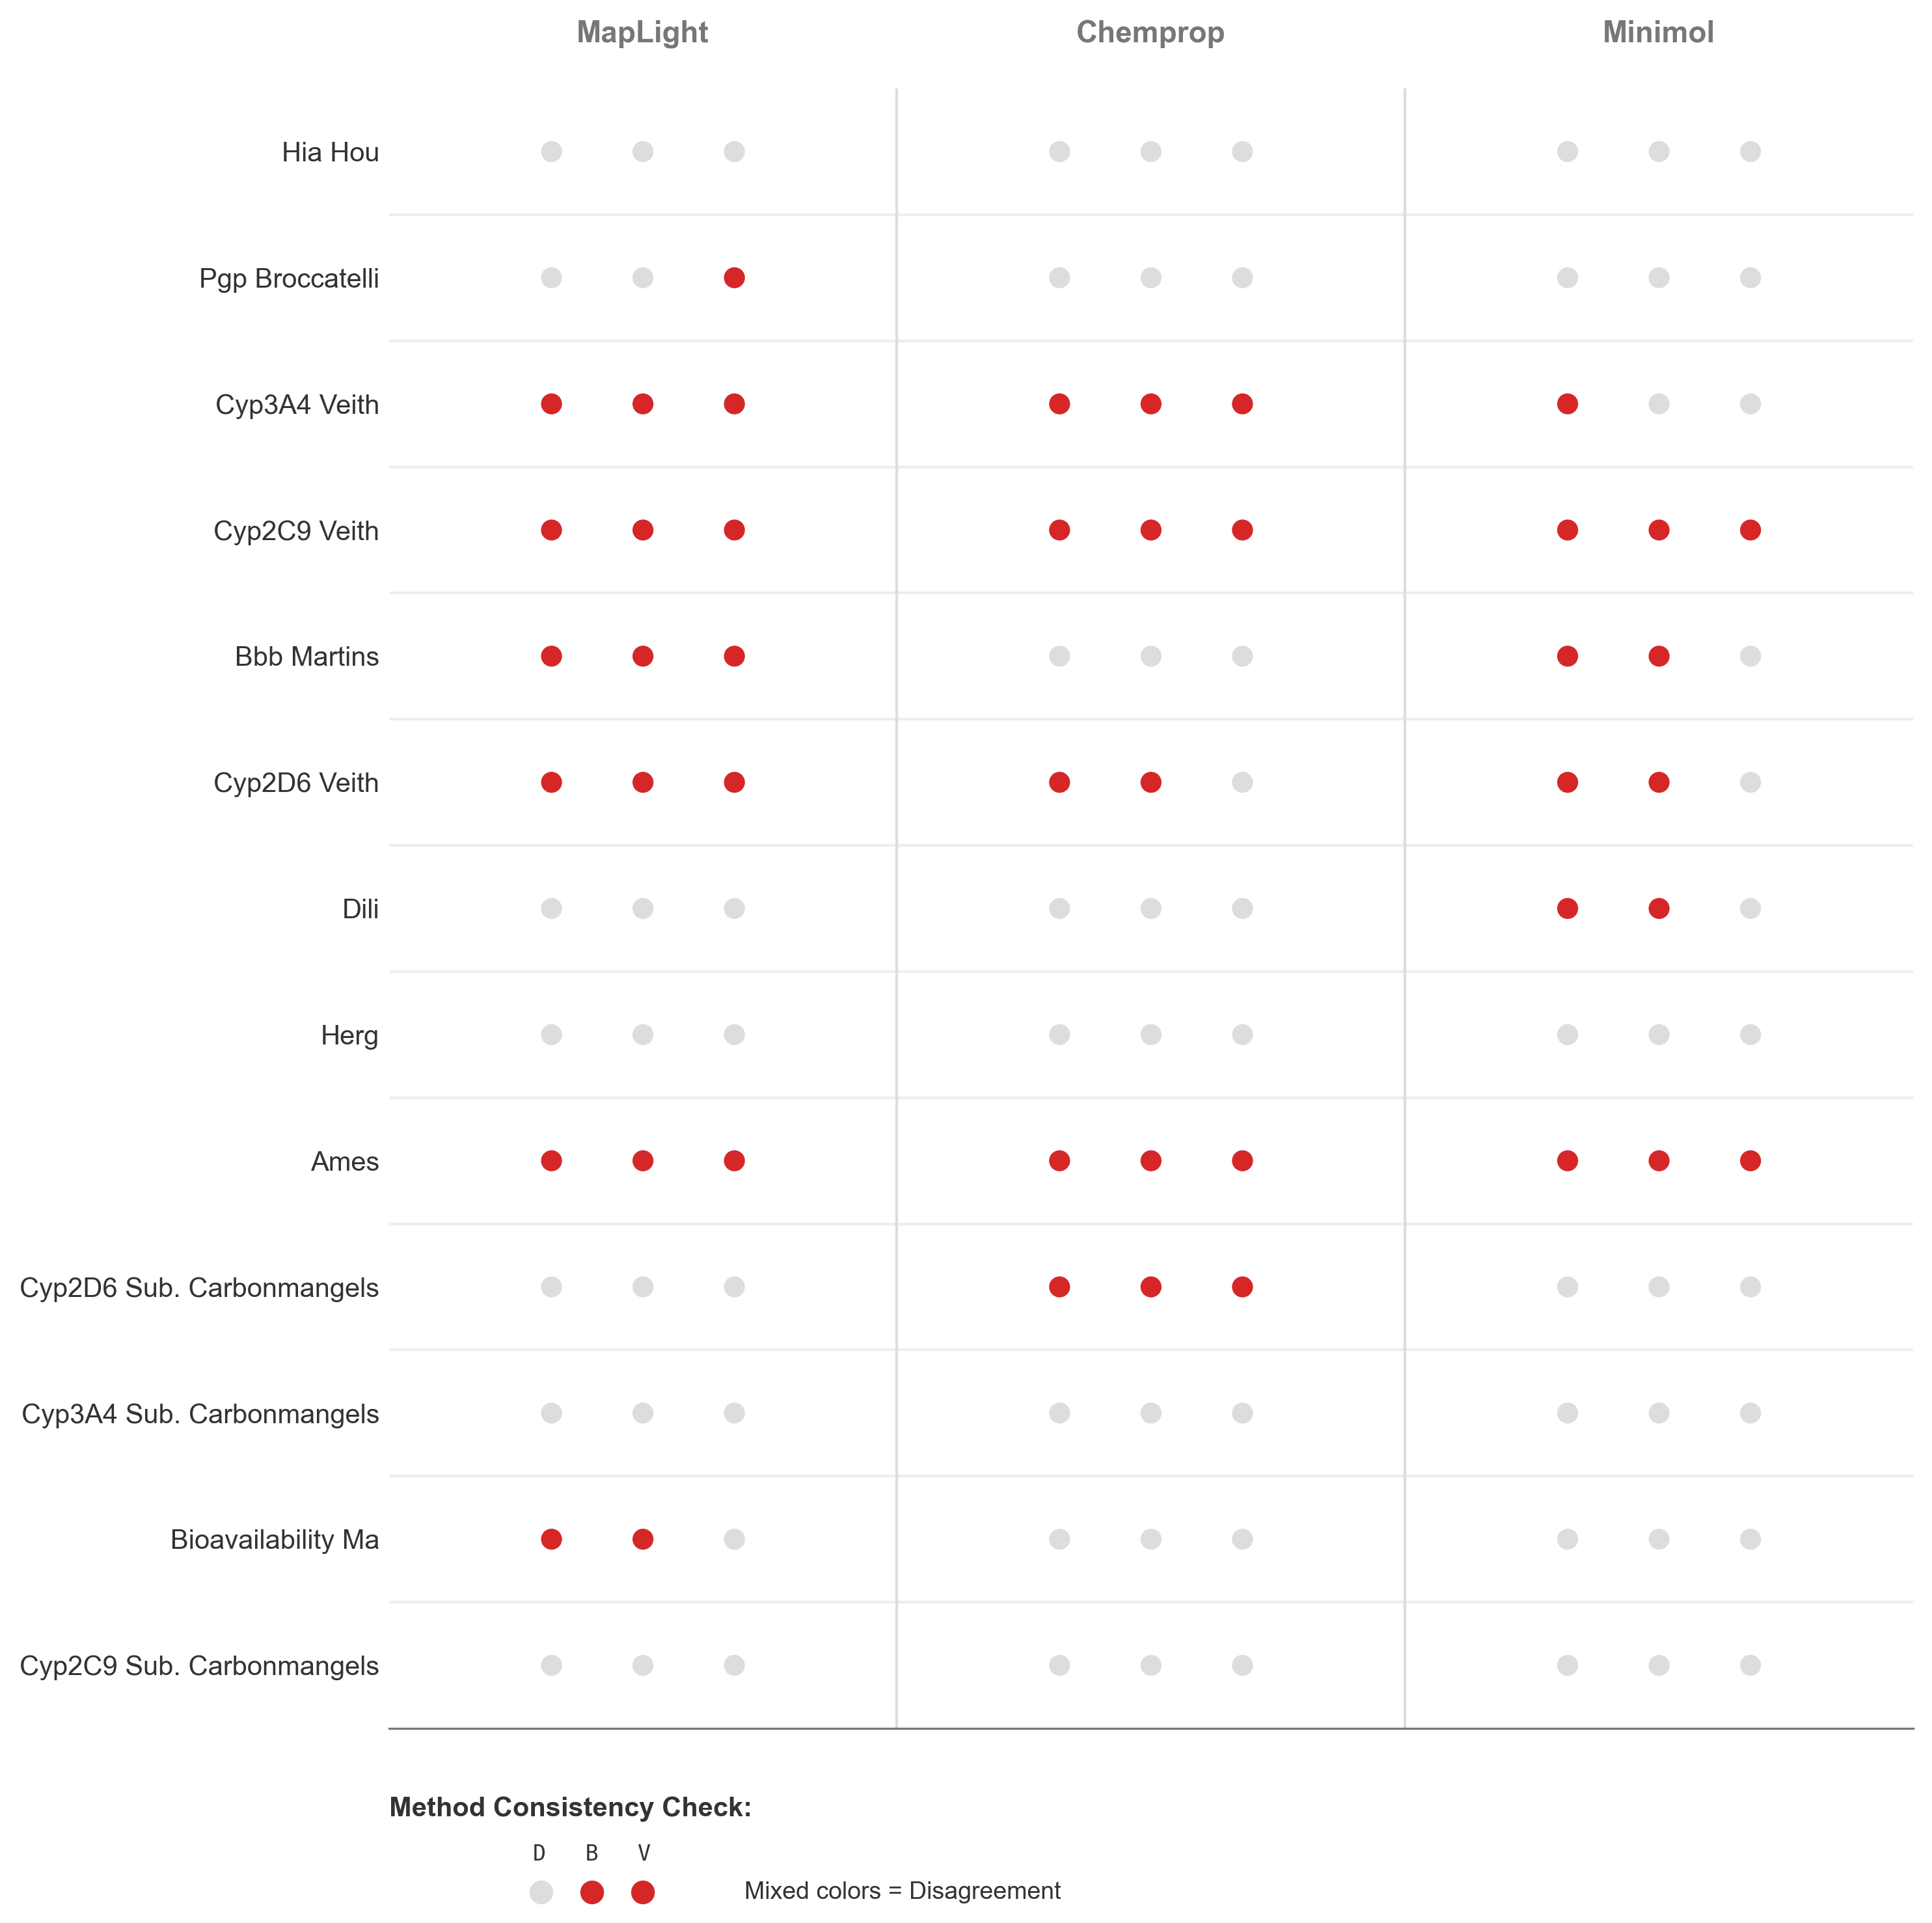

In [8]:
RESULTS_DIR = "plots"

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 10,
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'ytick.major.size': 0,
    'xtick.major.size': 0,
    'figure.dpi': 300,
    'legend.frameon': False
})

COLORS = {
    'Sig': '#D62728',     
    'NonSig': '#DDDDDD',  
    'Error': '#000000'    
}

BENCHMARK_CONFIG = [
    'hia_hou', 'pgp_broccatelli', 'bioavailability_ma', 'bbb_martins',
    'cyp2c9_veith', 'cyp2d6_veith', 'cyp3a4_veith',
    'cyp2c9_substrate_carbonmangels', 'cyp2d6_substrate_carbonmangels',
    'cyp3a4_substrate_carbonmangels', 'herg', 'ames', 'dili'
]

FILE_MAP = {
    'Baseline (ECFP4)': '../benchmark/baseline/baseline_ecfp4_binary.pickle',
    'MapLight': '../benchmark/maplight/maplight_binary.pickle',
    'Chemprop': '../benchmark/chemprop/chemprop_binary.pickle',
    'Minimol': '../benchmark/minimol/minimol_binary.pickle'
}

MODELS = ['MapLight', 'Chemprop', 'Minimol']

results_data = {k: pickle.load(open(v, 'rb')) for k, v in FILE_MAP.items()}
plot_data = []

base_aucs = {}
for dataset in BENCHMARK_CONFIG:
    d = results_data['Baseline (ECFP4)']
    if f"{dataset}_y_pred_proba" in d:
        y_score = d[f"{dataset}_y_pred_proba"]
        if y_score.ndim > 1: y_score = y_score[:, 1] if y_score.shape[1] == 2 else y_score.squeeze()
        if not np.isnan(y_score).any():
             roc = ROC(d[f"{dataset}_y_true"], y_score)
             base_aucs[dataset] = roc.auc

sorted_datasets = sorted(base_aucs, key=base_aucs.get)

for dataset in sorted_datasets:
    base_data = results_data['Baseline (ECFP4)']
    y_base = base_data[f"{dataset}_y_pred_proba"]
    if y_base.ndim > 1: y_base = y_base[:, 1] if y_base.shape[1] == 2 else y_base.squeeze()
    base_roc = ROC(base_data[f"{dataset}_y_true"], y_base)
    
    for model in MODELS:
        m_data = results_data[model]
        if f"{dataset}_y_pred_proba" not in m_data: continue
        
        y_model = m_data[f"{dataset}_y_pred_proba"]
        if y_model.ndim > 1: y_model = y_model[:, 1] if y_model.shape[1] == 2 else y_model.squeeze()
        if np.isnan(y_model).any(): continue

        model_roc = ROC(m_data[f"{dataset}_y_true"], y_model)
        if model_roc.auc <= base_roc.auc:
            p_vals = [1.0, 1.0, 1.0]
        else:
            try:
                p_delong = compare(model_roc, base_roc, method='delong', paired=True).p_value
                p_boot = compare(model_roc, base_roc, method='bootstrap', paired=True, n_boot=2000).p_value 
                p_venk = compare(model_roc, base_roc, method='venkatraman', paired=True, n_boot=2000).p_value 
                p_vals = [p_delong, p_boot, p_venk]
            except:
                p_vals = [1.0, 1.0, 1.0]
        
        plot_data.append({
            'dataset': dataset,
            'model': model,
            'p_vals': p_vals # [DeLong, Boot, Venk]
        })

fig, ax = plt.subplots(figsize=(10, 12))

y_ticks = np.arange(len(sorted_datasets))
model_x_centers = [1, 2, 3]
dot_spacing = 0.18 

ax.set_xlim(0.5, 3.5)
ax.set_ylim(-0.5, len(sorted_datasets)-0.5)

for y in y_ticks[:-1]:
    ax.axhline(y + 0.5, color='#EEEEEE', linewidth=1)
    
ax.axvline(1.5, color='#DDDDDD', linewidth=1)
ax.axvline(2.5, color='#DDDDDD', linewidth=1)

for entry in plot_data:
    y_idx = sorted_datasets.index(entry['dataset'])
    x_center = model_x_centers[MODELS.index(entry['model'])]
    
    p_vals = entry['p_vals']
    offsets = [-dot_spacing, 0, dot_spacing]
    
    for i, p in enumerate(p_vals):
        color = COLORS['Sig'] if p < 0.05 else COLORS['NonSig']
        
        all_sig = all(pv < 0.05 for pv in p_vals)
        all_nonsig = all(pv >= 0.05 for pv in p_vals)
        is_consistent = all_sig or all_nonsig
        
        ax.scatter(x_center + offsets[i], y_idx, 
                   s=60, color=color, edgecolors='none')

ax.set_yticks(y_ticks)
ax.set_yticklabels([d.replace('_',' ').replace('substrate','sub.').title() for d in sorted_datasets], 
                   fontsize=10, color='#333333')

ax.xaxis.tick_top()
ax.set_xticks(model_x_centers)
ax.set_xticklabels(MODELS, fontsize=11, weight='bold')
ax.tick_params(axis='x', pad=15)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS['Sig'], ms=8, label='Significant ($p<0.05$)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS['NonSig'], ms=8, label='Not Significant'),
    Line2D([0], [0], color='w', label='     '),
    Line2D([0], [0], marker='', color='w', label='$\\bf{Dot\ Order:}$'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#555555', ms=5, label='DeLong'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#555555', ms=5, label='Bootstrap'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#555555', ms=5, label='Venkatraman'),
]
ax.text(0.5, -1.2, "Method Consistency Check:", fontsize=10, weight='bold')
ax.scatter([0.8, 0.9, 1.0], [-1.8, -1.8, -1.8], s=60, c=[COLORS['NonSig'], COLORS['Sig'], COLORS['Sig']], clip_on=False)
ax.text(0.9, -1.5, "D   B   V", fontsize=8, ha='center', va='center', family='monospace')
ax.text(1.2, -1.8, "Mixed colors = Disagreement", fontsize=9, va='center')

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.15)
save_path = f"{RESULTS_DIR}/method_consistency_plot.pdf"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

In [9]:
RESULTS_DIR = "tables"

BENCHMARK_CONFIG = [
    'hia_hou', 'pgp_broccatelli', 'bioavailability_ma', 'bbb_martins',
    'cyp2c9_veith', 'cyp2d6_veith', 'cyp3a4_veith',
    'cyp2c9_substrate_carbonmangels', 'cyp2d6_substrate_carbonmangels',
    'cyp3a4_substrate_carbonmangels', 'herg', 'ames', 'dili'
]

FILE_MAP = {
    'Baseline (ECFP4)': '../benchmark/baseline/baseline_ecfp4_binary.pickle',
    'MapLight': '../benchmark/maplight/maplight_binary.pickle',
    'Chemprop': '../benchmark/chemprop/chemprop_binary.pickle',
    'Minimol': '../benchmark/minimol/minimol_binary.pickle'
}

MODELS_TO_COMPARE = ['MapLight', 'Chemprop', 'Minimol']

results_data = {k: pickle.load(open(v, 'rb')) for k, v in FILE_MAP.items()}
comparison_rows = []

for dataset in BENCHMARK_CONFIG:
    base_data = results_data['Baseline (ECFP4)']
    if f"{dataset}_y_pred_proba" not in base_data: continue
    
    y_base = base_data[f"{dataset}_y_pred_proba"]
    if y_base.ndim > 1: y_base = y_base[:, 1] if y_base.shape[1] == 2 else y_base.squeeze()
    if np.isnan(y_base).any(): continue
        
    base_roc = ROC(base_data[f"{dataset}_y_true"], y_base)
    for model_name in MODELS_TO_COMPARE:
        m_data = results_data[model_name]
        if f"{dataset}_y_pred_proba" not in m_data: continue
        
        y_model = m_data[f"{dataset}_y_pred_proba"]
        if y_model.ndim > 1: y_model = y_model[:, 1] if y_model.shape[1] == 2 else y_model.squeeze()
        if np.isnan(y_model).any(): continue

        model_roc = ROC(m_data[f"{dataset}_y_true"], y_model)
        auc_diff = model_roc.auc - base_roc.auc
        row = {
            'Dataset': dataset.replace('_', ' ').title(),
            'Model': model_name,
            'Delta_AUC': auc_diff
        }
        
        try:
            res_delong = compare(model_roc, base_roc, method='delong', paired=True)
            row['p_DeLong'] = res_delong.p_value
            
            res_boot = compare(model_roc, base_roc, method='bootstrap', paired=True, n_boot=2000)
            row['p_Boot'] = res_boot.p_value
            
            res_venk = compare(model_roc, base_roc, method='venkatraman', paired=True, n_boot=2000)
            row['p_Venk'] = res_venk.p_value
            
            sigs = [p < 0.05 for p in [res_delong.p_value, res_boot.p_value, res_venk.p_value]]
            if all(sigs):
                row['Consensus'] = "All Significant"
            elif not any(sigs):
                row['Consensus'] = "All Non-Sig"
            else:
                row['Consensus'] = "DISAGREEMENT"

        except Exception as e:
            row['Consensus'] = f"Error: {e}"

        comparison_rows.append(row)

df_comp = pd.DataFrame(comparison_rows)

def fmt_p(p):
    return f"{p:.4f}{'*' if p < 0.05 else ''}"

df_view = df_comp.copy()
for col in ['p_DeLong', 'p_Boot', 'p_Venk']:
    df_view[col] = df_view[col].apply(fmt_p)

csv_path = f"{RESULTS_DIR}/method_comparison.csv"
df_comp.to_csv(csv_path, index=False)

interesting_rows = df_view[df_view['Consensus'] != "All Non-Sig"]
if interesting_rows.empty:
    print("All methods agreed completely on all datasets (likely all non-significant).")
else:
    print(interesting_rows)

/var/folders/nj/v2qpgqmx5v95v_p1dzfj62yr0000gn/T/ipykernel_48679/26432772.py:19: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  results_data = {k: pickle.load(open(v, 'rb')) for k, v in FILE_MAP.items()}


                           Dataset     Model  Delta_AUC p_DeLong   p_Boot  \
3                  Pgp Broccatelli  MapLight   0.028592   0.0640   0.0654   
6               Bioavailability Ma  MapLight   0.078151  0.0370*  0.0369*   
9                      Bbb Martins  MapLight   0.048390  0.0006*  0.0007*   
11                     Bbb Martins   Minimol   0.046689  0.0090*  0.0082*   
12                    Cyp2C9 Veith  MapLight   0.024663  0.0000*  0.0000*   
13                    Cyp2C9 Veith  Chemprop   0.019965  0.0007*  0.0008*   
14                    Cyp2C9 Veith   Minimol   0.026349  0.0000*  0.0000*   
15                    Cyp2D6 Veith  MapLight   0.039648  0.0000*  0.0000*   
16                    Cyp2D6 Veith  Chemprop   0.016976  0.0347*  0.0346*   
17                    Cyp2D6 Veith   Minimol   0.021067  0.0280*  0.0282*   
18                    Cyp3A4 Veith  MapLight   0.029764  0.0000*  0.0000*   
19                    Cyp3A4 Veith  Chemprop   0.031527  0.0000*  0.0000*   

## Smoothing ROC Curves

Sometimes, ROC curves can appear jagged, especially with small datasets. The `smooth` function can be used to create a smoother version of a ROC curve.

/var/folders/nj/v2qpgqmx5v95v_p1dzfj62yr0000gn/T/ipykernel_48679/869117216.py:39: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  results_data = {k: pickle.load(open(v, 'rb')) for k, v in FILE_MAP.items()}


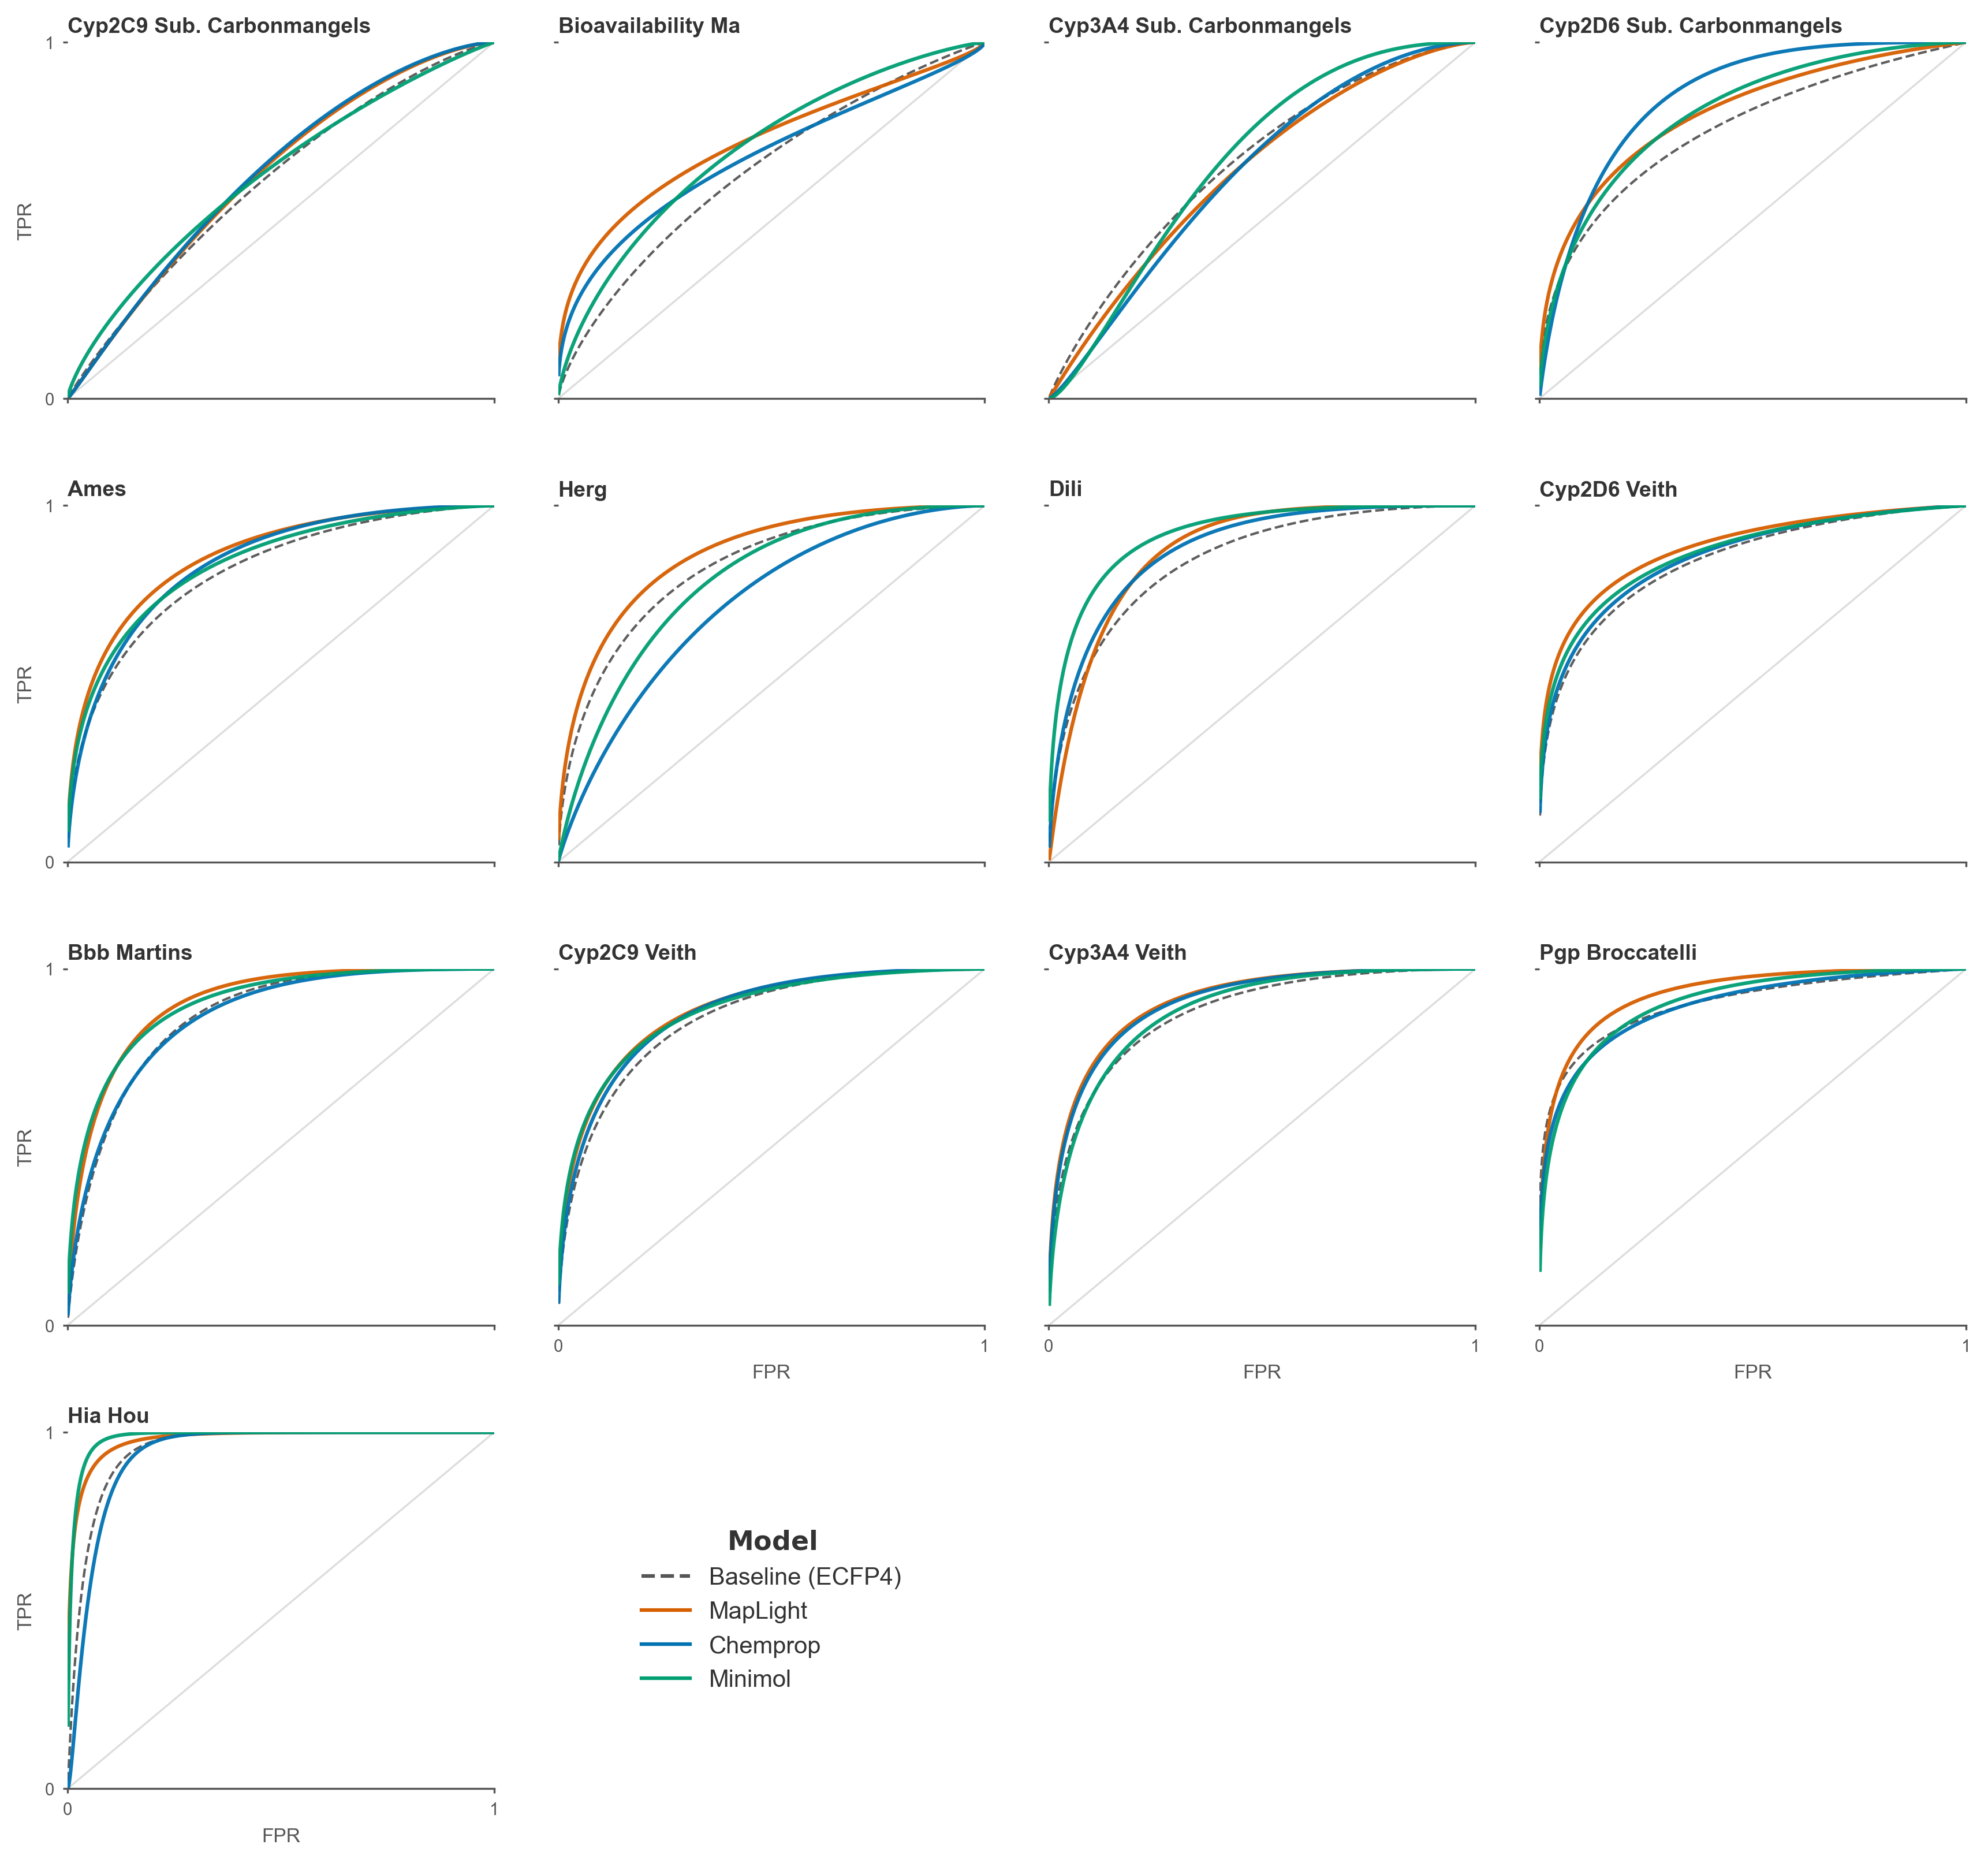

In [10]:
RESULTS_DIR = "plots"

COLORS = {
    'Baseline (ECFP4)': '#555555',  
    'MapLight': '#D55E00',          
    'Chemprop': '#0072B2',          
    'Minimol': '#009E73'            
}

LINESTYLES = {
    'Baseline (ECFP4)': '--', 
    'MapLight': '-',
    'Chemprop': '-',
    'Minimol': '-'
}

LINEWIDTHS = {
    'Baseline (ECFP4)': 1.0,
    'MapLight': 1.5,
    'Chemprop': 1.5,
    'Minimol': 1.5
}

BENCHMARK_CONFIG = [
    'hia_hou', 'pgp_broccatelli', 'bioavailability_ma', 'bbb_martins',
    'cyp2c9_veith', 'cyp2d6_veith', 'cyp3a4_veith',
    'cyp2c9_substrate_carbonmangels', 'cyp2d6_substrate_carbonmangels',
    'cyp3a4_substrate_carbonmangels', 'herg', 'ames', 'dili'
]

FILE_MAP = {
    'Baseline (ECFP4)': '../benchmark/baseline/baseline_ecfp4_binary.pickle',
    'MapLight': '../benchmark/maplight/maplight_binary.pickle',
    'Chemprop': '../benchmark/chemprop/chemprop_binary.pickle',
    'Minimol': '../benchmark/minimol/minimol_binary.pickle'
}

MODEL_ORDER = ['Baseline (ECFP4)', 'MapLight', 'Chemprop', 'Minimol']
results_data = {k: pickle.load(open(v, 'rb')) for k, v in FILE_MAP.items()}
plot_data = []
dataset_difficulty = {}

for dataset in BENCHMARK_CONFIG:
    d_base = results_data['Baseline (ECFP4)']
    pk = f"{dataset}_y_pred_proba"
    if pk in d_base:
        ys = d_base[pk]
        if ys.ndim > 1: ys = ys[:, 1] if ys.shape[1]==2 else ys.squeeze()
        if not np.isnan(ys).any():
            base_roc = pauc.ROC(d_base[f"{dataset}_y_true"], ys)
            dataset_difficulty[dataset] = base_roc.auc

    model_curves = []
    for model_name in MODEL_ORDER:
        d = results_data[model_name]
        pk = f"{dataset}_y_pred_proba"
        tk = f"{dataset}_y_true"
        
        if pk in d:
            y_score = d[pk]
            y_true = d[tk]
            
            if y_score.ndim > 1: y_score = y_score[:, 1] if y_score.shape[1] == 2 else y_score.squeeze()
            
            if not np.isnan(y_score).any():
                roc_obj = pauc.ROC(y_true, y_score, name=model_name)
                try:
                    smoothed_roc = pauc.smooth(roc_obj, method='binormal')
                    smoothed_roc.name = model_name 
                    model_curves.append(smoothed_roc)
                except Exception as e:
                    print(f"Warning: Smoothing failed for {model_name} on {dataset} ({e}). Using raw.")
                    model_curves.append(roc_obj)
    
    plot_data.append({
        'name': dataset,
        'curves': model_curves
    })

plot_data.sort(key=lambda x: dataset_difficulty.get(x['name'], 0))
rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
axes = axes.flatten()

plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5

for i, ax in enumerate(axes):
    if i < len(plot_data):
        data = plot_data[i]
        
        ax.plot([0, 1], [0, 1], color='#DDDDDD', lw=0.8, linestyle='-', zorder=0)
        
        for roc in data['curves']:
            ax.plot(roc.fpr, roc.tpr, 
                    color=COLORS[roc.name], 
                    linestyle=LINESTYLES[roc.name],
                    linewidth=LINEWIDTHS[roc.name],
                    label=roc.name,
                    alpha=0.95)
        
        clean_title = data['name'].replace('_', ' ').replace('substrate', 'sub.').title()
        ax.set_title(clean_title, fontsize=9, loc='left', weight='bold', pad=4)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#555555')
        ax.spines['bottom'].set_color('#555555')
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.tick_params(labelsize=7, colors='#555555', length=2)
        
        if i % cols == 0:
            ax.set_ylabel("TPR", fontsize=8, color='#555555')
        else:
            ax.set_yticklabels([])
            
        if i >= (len(plot_data) - cols):
             ax.set_xlabel("FPR", fontsize=8, color='#555555')
        else:
            ax.set_xticklabels([])
    else:
        ax.axis('off')

legend_ax = axes[13]
legend_ax.axis('off')
legend_elements = [
    Line2D([0], [0], color=COLORS['Baseline (ECFP4)'], lw=1.5, ls='--', label='Baseline (ECFP4)'),
    Line2D([0], [0], color=COLORS['MapLight'], lw=1.5, ls='-', label='MapLight'),
    Line2D([0], [0], color=COLORS['Chemprop'], lw=1.5, ls='-', label='Chemprop'),
    Line2D([0], [0], color=COLORS['Minimol'], lw=1.5, ls='-', label='Minimol')
]
legend_ax.legend(handles=legend_elements, loc='center', frameon=False, 
                 fontsize=10, title="$\\bf{Model}$", title_fontsize=11)

plt.tight_layout()
plt.subplots_adjust(top=0.88, right=0.95, wspace=0.15, hspace=0.3)

save_path = f"{RESULTS_DIR}/pauc_smoothed_roc_grid_fixed.pdf"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()